In [1]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import scipy as sp

# Data reading
import pandas as pd
import csv
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# networkx

import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import k_clique_communities

from community import community_louvain

import scipy.sparse.linalg

### Protein-protein interaction networks

The protein-protein interaction network of Yeast *saccharomyces cerevisiae* has more than $6,000$ proteins. Proteins form physical complexes of $5$-$50$ proteins and there are roughly $100$-$200$ functional communities. 

The gene CDC28 (*standard name*) is also called YOL068C (*systematic name*)

See https://www.yeastgenome.org for details; the data can be dowloaded from https://string-db.org/cgi/network.pl?taskId=nhiAd00Ggrzi

Thanks to Eduardo Altmann for sharing his Jupyter notebooks from which we have shamelessly copied

# I. Read in networks 

In [2]:
# Read networks from file
#G_CDC28=nx.read_weighted_edgelist("./../Data/4932_protein_links_v11_0.txt",comments="#",nodetype=str)
G_CDC28=nx.read_weighted_edgelist("4932.protein.links.v11.0.txt",comments="#",nodetype=str)

print('number of nodes of G:',nx.number_of_nodes(G_CDC28))
print('number of edges of G:',nx.number_of_edges(G_CDC28))

number of nodes of G: 6574
number of edges of G: 922983


In [8]:
node_target = '4932.YBR160W' #CDC28
print('The target node has %i links'%G_CDC28.degree(node_target))

The target node has 1401 links


In [3]:
# Choose the network to be analyzed below
G0=G_CDC28

print('number of nodes of the full G:',len(G0.nodes))
print('number of edges of the full G:',nx.number_of_edges(G0))
print('Is the full G connected?',nx.connected.is_connected(G0))
print('How many connected subgraphs are there?',nx.connected.number_connected_components(G0))

# delete those edges with a combined score of <= thershold_score (small confidence)
threshold_score = 700
#threshold_score = 0

for edge in G0.edges: 
    G0.get_edge_data(edge[0],edge[1])
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    #print('qwe',weight[0])
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])

# restrict to largest connected component
largest_cc = max(nx.connected_components(G0),key=len)
G0=G0.subgraph(largest_cc)
print('number of nodes of restricted G:',len(G0.nodes))
print('number of edges of restricted G:',nx.number_of_edges(G0))

# randomize according to degree-preserving Maslov-Sneppen algorithm
# G0_randomized = nx.random_reference(G0,connectivity=True) 


number of nodes of the full G: 6574
number of edges of the full G: 922983
Is the full G connected? False
How many connected subgraphs are there? 4
number of nodes of restricted G: 6099
number of edges of restricted G: 118661


# II.  Community detection

In [10]:
def partToList(part):
    '''Print partition as a list'''
    N=0
    for b in range(len(part)):
        N=N+len(part[b])
    listP=np.zeros(N)
    for b in range(len(part)):
        for n in part[b]:
            listP[n]=b
    return(listP)

def partToList_for_strings(part,G):
    '''Print partition as a list'''
    N=0
    for b in range(len(part)):
        N=N+len(part[b])
    listP=np.zeros(N)
    for b in range(len(part)):
        for n in part[b]:
            ind_n = list(G.nodes).index(n)
            listP[ind_n]=b
    return(listP)

## II a. Spectral methods

## Modularity

In [11]:
G0_mod = nx.modularity_matrix(G0, nodelist=None, weight=None)

# modularity (is numpy.matrix)
EVal, EVec = np.linalg.eig(G0_mod)
idx = np.argsort(EVal)
idx = idx[::-1]
EVal_mod = EVal.real[idx]
EVec_mod = EVec[:,idx]
print('lambda_mod=',EVal_mod[1:6])

lambda_mod= [132.75162033  73.08658256  68.96310303  65.40152253  59.47147851]


In [12]:
partClub = np.sign(EVec_mod.real[:,0])
ind_neg = [i for i in range(len(partClub)) if partClub[i]<0] 
ind_pos = [i for i in range(len(partClub)) if partClub[i]>0] 
partClub = (ind_neg,ind_pos)

## Random walk (almost invariant sets)

In [13]:
G0_Ad = nx.adjacency_matrix(G0, nodelist=None, weight=None)
# adjacency matrix (is scipy.sparse.csr.csr_matrix)

G0_D = G0_Ad.sum(axis=1)
G0_D = sp.sparse.spdiags(G0_D.flatten(), [0], len(G0.nodes), len(G0.nodes), format='csr')
G0_Markov = sp.sparse.linalg.inv(G0_D).dot(G0_Ad) # right eigenvector (expectation values)
G0_Markov = G0_Ad.dot(sp.sparse.linalg.inv(G0_D)) # left eigenvector (density)

# Markov matrix (is scipy.sparse.csr.csr_matrix)
G0_Markov = G0_Markov.astype(float);
EVal, EVec = sp.sparse.linalg.eigs(G0_Markov,k=6)
idx = np.argsort(EVal)
idx = idx[::-1]
EVal_Markov = EVal.real[idx]
EVec_Markov = EVec[:,idx]
print('lambda_Markov=',EVal_Markov.real)

lambda_Markov= [1.         0.97497165 0.96275612 0.96114214 0.94335489 0.9417598 ]


In [14]:
partClub = np.sign(EVec_Markov.real[:,1])
ind_neg = [i for i in range(len(partClub)) if partClub[i]<0] 
ind_pos = [i for i in range(len(partClub)) if partClub[i]>0] 
partClub = (ind_neg,ind_pos)

## Graph Laplacian

lambda_Lap= [-2.13355289e-14  1.53467561e-01  1.55249731e-01  1.72741735e-01
  1.74432318e-01  1.95654714e-01  2.04886022e-01  2.51977519e-01
  2.58276731e-01  2.68142580e-01  2.83601083e-01  2.90202059e-01
  3.03660289e-01  3.10116967e-01  3.12830719e-01]


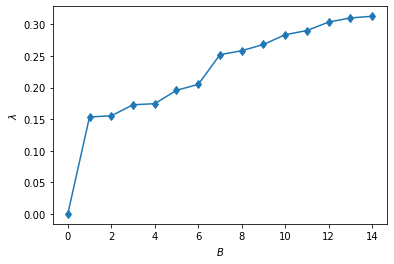

In [4]:
G0_Lap = nx.laplacian_matrix(G0, nodelist=None, weight=None)

# graph Laplacian matrix (is scipy.sparse.csr.csr_matrix)
G0_Lap = G0_Lap.astype(float)

EVal, EVec = sp.sparse.linalg.eigs(G0_Lap,k=15,which='SR')
idx = np.argsort(EVal)
#idx = idx[::-1]
EVal_Lap = EVal.real[idx]
EVec_Lap = EVec[:,idx]
print('lambda_Lap=',EVal_Lap)

#G0_lap_v2 = nx.fiedler_vector(G0, weight=None, normalized=False, tol=1e-08, seed=None)

## compare different eigenvalue routines (don't trust the higher ones)
# e = np.linalg.eigvals(G0_Lap.A)
# L.A is shorthand for L.toarray()

plt.plot(EVal_Lap,"-d")
plt.xlabel("$B$")
plt.ylabel("$\lambda$")
plt.show()

In [16]:
partClub = np.sign(EVec_Lap.real[:,1])

ind_neg = [i for i in range(len(partClub)) if partClub[i]<0] 
ind_pos = [i for i in range(len(partClub)) if partClub[i]>0] 
partClub = (ind_neg,ind_pos)

## Normalized Graph Laplacian

In [17]:
G0_normLap = nx.normalized_laplacian_matrix(G0, nodelist=None, weight=None)

# normalized graph Laplacian matrix (is scipy.sparse.csr.csr_matrix)
G0_normLap = G0_normLap.astype(float)
EVal, EVec = sp.sparse.linalg.eigs(G0_normLap,k=6,which='SR')
idx = np.argsort(EVal)
#idx = idx[::-1]
EVal_normLap = EVal.real[idx]
EVec_normLap = EVec[:,idx]
print('lambda_normLap=',EVal_normLap)

G0_normlap_v2 = nx.fiedler_vector(G0, weight=None, normalized=True, tol=1e-08, seed=None)


lambda_normLap= [-1.38777878e-17  2.50283518e-02  3.72438779e-02  3.88578578e-02
  5.66451112e-02  5.82402037e-02]


In [18]:
partClub = np.sign(EVec_normLap.real[:,1])

ind_neg = [i for i in range(len(partClub)) if partClub[i]<0] 
ind_pos = [i for i in range(len(partClub)) if partClub[i]>0] 
partClub = (ind_neg,ind_pos)

## Adjacency matrix

lambda_Ad= [211.61487807 136.01214958  85.86439381  71.13487642  68.02618983
  59.63148295]


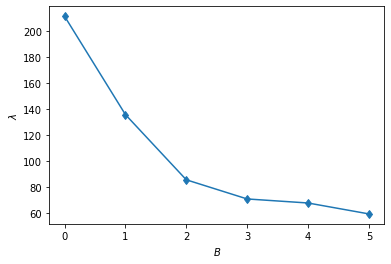

In [19]:
G0_Ad = nx.adjacency_matrix(G0, nodelist=None, weight=None)

# adjacency matrix (is scipy.sparse.csr.csr_matrix)
G0_Ad = G0_Ad.astype(float)
EVal, EVec = sp.sparse.linalg.eigs(G0_Ad,k=6,which='LR')
idx = np.argsort(EVal)
idx = idx[::-1]
EVal_Ad = EVal.real[idx]
EVec_Ad = EVec[:,idx]
print('lambda_Ad=',EVal_Ad)

plt.plot(EVal_Ad,"-d")
plt.xlabel("$B$")
plt.ylabel("$\lambda$")
plt.show()

In [20]:
partClub = np.sign(EVec_Ad.real[:,1])
ind_neg = [i for i in range(len(partClub)) if partClub[i]<0] 
ind_pos = [i for i in range(len(partClub)) if partClub[i]>0] 
partClub = (ind_neg,ind_pos)

## II b. Modularity community detection algorithms

### Louvain group modularity algorithm

!pip3 install python-louvain

https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008

https://en.wikipedia.org/wiki/Louvain_modularity


In [21]:
partLouvain = community_louvain.best_partition(G0)
number_of_communities = max(list(partLouvain.values()))+1
print('# of partitions for Louvain modularity =',number_of_communities)

# of partitions for Louvain modularity = 16


#### identify the community to which CDC28 (=YBR160W) belongs to (cluster starts at 0)

In [22]:
node_target = '4932.YBR160W' # CDC28
print('The target protein CDC28 belongs to community #',partLouvain[node_target])

The target protein CDC28 belongs to community # 6


#### find the communities to which this community connects to

In [23]:
# define the communities as separate graphs

#subgraph dict with community number as key and subgraph as value
G_cluster = {}

#node dict with community number as key and node as value
nodes = {}
for i in range(number_of_communities):
    nodes[i] = []

for name, community in partLouvain.items():
    nodes[community].append(name)
    
for key in nodes.keys():
    G_cluster[key] = G0.subgraph(nodes[key])
    

#### find the communities which have links to the community of the target protein

In [24]:
edges = {}
for i in range(number_of_communities-1):
    for j in range(i+1,number_of_communities):
        edges[str(i)+str(j)] = 0

for i in range(number_of_communities-1):
    for node in G_cluster[i].nodes():
        for neighbor in G0.neighbors(node):
            for j in range(i+1,number_of_communities):
                if neighbor in nodes[j]:
                    edges[str(i)+str(j)] += 1
print(edges) # convention: 'ij' denotes the edge between node i and node j

{'01': 0, '02': 1, '03': 0, '04': 1, '05': 0, '06': 4, '07': 1, '08': 0, '09': 0, '010': 0, '011': 0, '012': 0, '013': 0, '014': 0, '015': 0, '12': 539, '13': 737, '14': 753, '15': 1440, '16': 933, '17': 347, '18': 50, '19': 321, '110': 219, '111': 0, '112': 85, '113': 42, '114': 14, '115': 1, '23': 792, '24': 616, '25': 384, '26': 587, '27': 697, '28': 222, '29': 19, '210': 7061, '211': 0, '212': 57, '213': 7, '214': 23, '215': 0, '34': 231, '35': 334, '36': 1511, '37': 193, '38': 34, '39': 224, '310': 130, '311': 0, '312': 7, '313': 3, '314': 6, '315': 0, '45': 1176, '46': 229, '47': 127, '48': 53, '49': 26, '410': 177, '411': 2, '412': 27, '413': 17, '414': 15, '415': 0, '56': 671, '57': 152, '58': 110, '59': 45, '510': 339, '511': 2, '512': 82, '513': 33, '514': 18, '515': 0, '67': 1067, '68': 28, '69': 708, '610': 993, '611': 1, '612': 44, '613': 18, '614': 4, '615': 1, '78': 31, '79': 80, '710': 951, '711': 0, '712': 9, '713': 8, '714': 2, '715': 0, '89': 5, '810': 127, '811': 0,

In [25]:
# Find the communities which have links to the community of the target protein
target_cluster = partLouvain[node_target]
neighbor_cluster = []
for i in range(number_of_communities):
    if i < target_cluster:
        if edges[str(i)+str(target_cluster)] != 0:
            neighbor_cluster.append(i)
    if i > target_cluster:
        if edges[str(target_cluster)+str(i)] != 0:
            neighbor_cluster.append(i)
        
print(neighbor_cluster)


[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15]


#### find the central nodes for each cluster

In [26]:
top10_final = {}
for i in range(number_of_communities):
    top10_final[i] = []
    G = G_cluster[i]
    measuresNames=["Degree","Eigenvector","Katz","Page Rank","Betweeness"]
    if len(G.nodes)>2:
        listMeasures = [dict(nx.degree(G)),nx.eigenvector_centrality_numpy(G),nx.katz_centrality_numpy(G),nx.pagerank(G),nx.betweenness_centrality(G)]
   
    if len(G.nodes)<=2:
        listMeasures = [dict(nx.degree(G)),nx.eigenvector_centrality(G),nx.katz_centrality(G),nx.pagerank(G),nx.betweenness_centrality(G)]
   
    for idx,dictMeasure in enumerate(listMeasures):
        top10 = [[dictMeasure[k],k] for k in dictMeasure.keys()] # Choose the 10 largest values
        top10.sort(reverse=True)
        top10_final[i].append(top10)
        print("\n Centrality Measure in Cluster:",str(i),measuresNames[idx])
        for idx,pair in enumerate(top10[:10]):
            print(str(idx+1),": \t is node ",pair[1],' with value: %.4f \t' %(pair[0]))


4932.YGR094W  with value: 37.0000 	

 Centrality Measure in Cluster: 8 Eigenvector
1 : 	 is node  4932.YGR094W  with value: 0.1778 	
2 : 	 is node  4932.YBL076C  with value: 0.1769 	
3 : 	 is node  4932.YPL160W  with value: 0.1764 	
4 : 	 is node  4932.YGR185C  with value: 0.1761 	
5 : 	 is node  4932.YDR023W  with value: 0.1754 	
6 : 	 is node  4932.YIL078W  with value: 0.1754 	
7 : 	 is node  4932.YDR037W  with value: 0.1752 	
8 : 	 is node  4932.YGR264C  with value: 0.1745 	
9 : 	 is node  4932.YNL073W  with value: 0.1738 	
10 : 	 is node  4932.YOR335C  with value: 0.1731 	

 Centrality Measure in Cluster: 8 Katz
1 : 	 is node  4932.YIL054W  with value: 0.2776 	
2 : 	 is node  4932.YNL140C  with value: 0.2776 	
3 : 	 is node  4932.YLR358C  with value: 0.2776 	
4 : 	 is node  4932.YHR173C  with value: 0.2776 	
5 : 	 is node  4932.YNL184C  with value: 0.2755 	
6 : 	 is node  4932.YOR105W  with value: 0.2615 	
7 : 	 is node  4932.YER084W  with value: 0.2615 	
8 : 	 is node  4932.YNL143

In [27]:
# write data file
central_nodes = {'COMMUNITY':[], 'RANK':[], 'DEGREE_NODE':[],'DEGREE_VALUE':[], 'EIGENVECTOR_NODE':[],'EIGENVECTOR_VALUE':[], 'KATZ_NODE':[], 'KATZ_VALUE':[], 'PAGERANK_NODE':[], 'PAGERANK_VALUE':[], 'BETWEENESS_NODE':[], 'BETWEENESS_VALUE':[]}
 
for i in range(number_of_communities):
    G = G_cluster[i]
    #the number of nodes in top10 central nodes
    row_number = min(len(G.nodes),10)
    central_nodes['COMMUNITY'].extend([i]*row_number)
    central_nodes['RANK'].extend(list(range(1,row_number+1)))
    
    for j in range(row_number):
        central_nodes['DEGREE_NODE'].append(top10_final[i][0][j][1][5:])
        central_nodes['DEGREE_VALUE'].append(top10_final[i][0][j][0])
        central_nodes['EIGENVECTOR_NODE'].append(top10_final[i][1][j][1][5:])
        central_nodes['EIGENVECTOR_VALUE'].append(top10_final[i][1][j][0])
        central_nodes['KATZ_NODE'].append(top10_final[i][2][j][1][5:])
        central_nodes['KATZ_VALUE'].append(top10_final[i][2][j][0])
        central_nodes['PAGERANK_NODE'].append(top10_final[i][3][j][1][5:])
        central_nodes['PAGERANK_VALUE'].append(top10_final[i][3][j][0])
        central_nodes['BETWEENESS_NODE'].append(top10_final[i][4][j][1][5:])
        central_nodes['BETWEENESS_VALUE'].append(top10_final[i][4][j][0])

df = pd.DataFrame(central_nodes, columns= ['COMMUNITY','RANK', 'DEGREE_NODE','DEGREE_VALUE', 'EIGENVECTOR_NODE','EIGENVECTOR_VALUE', 'KATZ_NODE', 'KATZ_VALUE', 'PAGERANK_NODE', 'PAGERANK_VALUE', 'BETWEENESS_NODE', 'BETWEENESS_VALUE'])
df.to_csv("CDC28_Centrality_Louvain_thresh%s.csv" %threshold_score, index=False)


In [28]:
# write data file
top10_final = {}
for i in range(number_of_communities):
    top10_final['COMMUNITY' + str(i)] = []
    G = G_cluster[i]
    measuresNames=["Degree","Eigenvector","Katz","Page Rank","Betweeness"]
    if len(G.nodes)>2:
        listMeasures = [dict(nx.degree(G)),nx.eigenvector_centrality_numpy(G),nx.katz_centrality_numpy(G),nx.pagerank(G),nx.betweenness_centrality(G)]
   
    if len(G.nodes)<=2:
        listMeasures = [dict(nx.degree(G)),nx.eigenvector_centrality(G),nx.katz_centrality(G),nx.pagerank(G),nx.betweenness_centrality(G)]
   
    for idx,dictMeasure in enumerate(listMeasures):
        top10 = [[dictMeasure[k],k] for k in dictMeasure.keys()] # Choose the 10 largest values
        top10.sort(reverse=True)
        for idx,pair in enumerate(top10[:10]):
            top10_final['COMMUNITY' + str(i)].append(pair[1])    
        if len(G.nodes)< 10:
            top10_final['COMMUNITY' + str(i)].extend(['None']*(10-len(G.nodes)))
df = pd.DataFrame(top10_final, columns= list(top10_final.keys()))
df.to_csv("CDC28_Centrality_Louvain_thresh%s_singlecolumn.csv" %threshold_score, index=False)

# III. Analysis

In [29]:
# specify the partition to be analyzed
partComm = partLouvain

## Avenue #1:
### restrict analysis to the cluster of the target node and identify the shortest path between the target node and one of the most central nodes of that same community

In [30]:
# restrict to community of target node
comm_target = partComm[node_target]
G_av1 = G_cluster[comm_target]

#node_central = '4932.YNL031C'
node_central = '4932.YLR199C' # telomere maintenance
#node_central = '4932.YBL021C' # metabolism

shortest_path_av1 = nx.shortest_path(G_av1, source=node_target, target=node_central)
len_shortest_path_av1 = len(list(shortest_path_av1))

print('shortest path between the target protein and the specified central node:', shortest_path_av1)
#print(list(nx.all_simple_paths(G_av1, source=node_target, target=node_central, cutoff=len_shortest_path_av1+1)))


NodeNotFound: Either source 4932.YBR160W or target 4932.YLR199C is not in G

# VI. Centrality measures 

## Clustering

$\large{C_{net}}$

In [44]:
#G=G_CDC28
G = G0
G_randomized = nx.random_reference(G,connectivity=True) 
print('C_net of G:',nx.transitivity(G))
print('C_net of randomized G:',nx.transitivity(G_randomized));

KeyboardInterrupt: 

In [48]:
cluster=nx.clustering(G,nodes=G.nodes)

In [ ]:
#print('Clustering:',nx.clustering(G))
totalC=0
cluster=nx.clustering(G,nodes=G.nodes)
cluster_keys=list(cluster)
cluster_values=list(cluster.values())
for n in range(len(G.nodes)):
    totalC = totalC+cluster_values[n]
print("Average clustering of G = "+str(totalC/nx.number_of_nodes(G)) )

totalC=0
cluster=nx.clustering(G_randomized,nodes=G_randomized.nodes)
cluster_keys=list(cluster)
cluster_values=list(cluster.values())
for n in range(len(G_randomized.nodes)):
    totalC = totalC+cluster_values[n]
print("Average clustering of randomized G= "+str(totalC/nx.number_of_nodes(G_randomized)) )


## Degree

In [49]:
dgList=[]
#print('asd',G.degree)
for i in G.degree():
    dgList.append([i[1],i[0]])
dgList.sort()
dgList.reverse()
for j in dgList[:10]:
    print("Node "+str(j[1])+" has degree "+str(j[0])) 

Node 4932.YLR167W has degree 481
Node 4932.YKR094C has degree 463
Node 4932.YLL039C has degree 409
Node 4932.YNL178W has degree 384
Node 4932.YKL009W has degree 384
Node 4932.YJR123W has degree 367
Node 4932.YGL123W has degree 354
Node 4932.YDR064W has degree 352
Node 4932.YDL014W has degree 347
Node 4932.YCR031C has degree 346


## Shortest path

In [ ]:
dij=dict(nx.shortest_path_length(G))
diList=[]
for k in dij:
    di=np.average(list(dict(dij[k]).values()))
    diList.append([di,k])

diList.sort()
print("Top 10 nodes with shortest <d_i>:\n")
for i in diList[:10]:
    print("\t Node i=",i[1]," has <d_i>=",i[0])

## Betweeness centrality

In [ ]:
nx.betweenness_centrality(G);

In [ ]:
nx.betweenness_centrality(G_randomized);

## Eigenvector

In [ ]:
nx.eigenvector_centrality(G);

In [ ]:
nx.eigenvector_centrality(G_randomized);

In [ ]:
measuresNames=["Degree","Eigenvector","Katz","Page Rank","Betweeness"]
listMeasures = [dict(nx.degree(G)),nx.eigenvector_centrality_numpy(G),nx.katz_centrality_numpy(G),nx.pagerank(G),nx.betweenness_centrality(G)]

for idx,dictMeasure in enumerate(listMeasures):
    top10 = [[dictMeasure[k],k] for k in dictMeasure.keys()] # Choose the 10 largest values
    top10.sort(reverse=True)
    print("\n Centrality Measure:",measuresNames[idx])
    for idx,pair in enumerate(top10[:10]):
        print(str(idx+1),": \t is node ",pair[1]," with value:\t",pair[0])

In [ ]:
measuresNames=["Degree","Eigenvector","Katz","Page Rank","Betweeness"]
listMeasures = [dict(nx.degree(G_randomized)),nx.eigenvector_centrality_numpy(G_randomized),nx.katz_centrality_numpy(G_randomized),nx.pagerank(G_randomized),nx.betweenness_centrality(G_randomized)]

for idx,dictMeasure in enumerate(listMeasures):
    top10 = [[dictMeasure[k],k] for k in dictMeasure.keys()] # Choose the 10 largest values
    top10.sort(reverse=True)
    print("\n Centrality Measure:",measuresNames[idx])
    for idx,pair in enumerate(top10[:10]):
        print(str(idx+1),": \t is node ",pair[1]," with value:\t",pair[0])